# EDA, Data Cleaning, Modeling

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
X = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv")
y = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv")
X.shape, y.shape

((59400, 40), (59400, 2))

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
X.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
y.head(2)

,id,status_group
0,69572,functional
1,8776,functional


## 1. Baseline Accuracy (54.3%)

In [6]:
y["status_group"].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## 2. First Model with All 9 Numeric Features

In [7]:
X_num = X.select_dtypes(include="number")

In [8]:
X_num = X_num.drop(columns = "id")

In [9]:
X_num.head(3)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,25.0,686,37.460664,-3.821329,0,21,4,250,2009


In [10]:
y = y["status_group"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, random_state=42, stratify=y)

In [12]:
ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_test, y_test)

0.5582491582491582

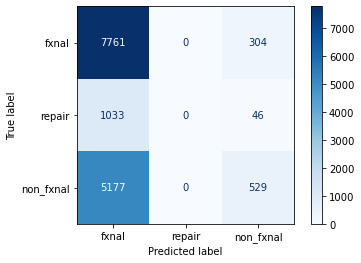

In [13]:
ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test, cmap ="Blues", display_labels=["fxnal", "repair", "non_fxnal"]);

> This model is very much the same as the null model which predicts all pumps functional

## 3. Examine Categorical Features (30 total)

### 3.1. date_recorded

In [14]:
X["date_recorded"].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64

> This columns should be converted to datetime data type
>
> Group them by month maybe, to reduce the number of values

### 3.2. funder

In [15]:
X["funder"].value_counts()  #many

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1897, dtype: int64

### 3.3. installer

In [16]:
X["installer"].value_counts()  #many

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2145, dtype: int64

### 3.4. wpt_name

In [17]:
X["wpt_name"].value_counts()  #too many

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

### 3.5. basin, subvillage, region

In [18]:
X["basin"].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [19]:
X["region"].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [20]:
X["subvillage"].value_counts()  #too many

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

> From big to small: basin > region > subvillage
>
> Probably use region only

### 3.6. ward, lga

In [21]:
X["ward"].value_counts()  #many

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

In [22]:
X["lga"].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

> LGA is Local Government Area. Each LGA contains many wards.
>
> Maybe use LGA only (still alot, 125 of them)

### 3.7. public_meeting

In [23]:
X["public_meeting"].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

> Convert to numeric: 1 for True, 0 for False

### 3.8. recorded_by

In [24]:
X["recorded_by"].value_counts()  #only 1 value, not useful

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

### 3.9. scheme_management, scheme_name

In [25]:
X["scheme_management"].value_counts()  #names look similar to management in 3.12

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [26]:
X["scheme_name"].value_counts()   #many names

K                       682
None                    644
Borehole                546
Chalinze wate           405
M                       400
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: scheme_name, Length: 2696, dtype: int64

### 3.10. permit

In [27]:
X["permit"].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

> Convert to numeric: 1 for True, 0 for False

### 3.11. extraction_type, extraction_type_group, extraction_type_class

In [28]:
X["extraction_type"].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [29]:
X["extraction_type_group"].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [30]:
X["extraction_type_class"].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

> extraction_type_group is aggregated from extraction_type
>
> extraction_type_class is aggreated from extraction_type_group
>
> Rank from most to least compact: extraction_type_class > extraction_type_group > extraction_type
>
> Use extraction_type only

### 3.12. management, management_group

In [31]:
X["management"].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [32]:
X["management_group"].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

> Keep management only

### 3.13. payment, payment_type (identical)

In [33]:
X["payment"].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [34]:
X["payment_type"].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

> The 2 are identical, keep 1 only

### 3.14. water_quality, quality_group

In [35]:
X["water_quality"].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [36]:
X["quality_group"].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

> Keep water_quality only, it has a bit more details

### 3.15. quantity, quantity_group  (identical)

In [37]:
X["quantity"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [38]:
X["quantity_group"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

> The 2 are identical, keep 1 only

### 3.16. source, source_type, source_class

In [39]:
X["source"].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [40]:
X["source_type"].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [41]:
X["source_class"].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

> Same infomation, different level of detail, keep "source" only

### 3.17. waterpoint_type, waterpoint_type_group

In [42]:
X["waterpoint_type"].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [43]:
X["waterpoint_type_group"].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

> Keep waterpoint_type only, it has a bit more details

## 4. Modeling

In [44]:
X["datetime_recorded"] = pd.to_datetime(X["date_recorded"])
#356 different values

In [45]:
X["year_month_recorded"] = X["datetime_recorded"].dt.to_period('M').dt.strftime("%Y-%m")
#keep only year and month
#reduce to 38 different values

In [46]:
#w/out date_recorded, less features, run faster, acc = 74.8%
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type",
             "date_recorded"]

In [47]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
date_recorded           0
dtype: int64

In [48]:
X_cat.shape

(59400, 13)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

### 4.1. Logistic Regression

#### 4.1.1. SimpleImputer

In [50]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train).round(3), pipe1.score(X_test, y_test).round(3)

(0.756, 0.753)

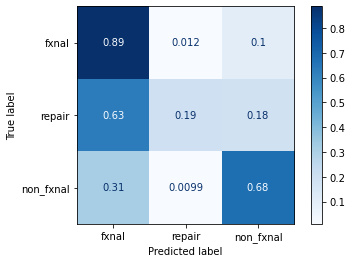

In [51]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

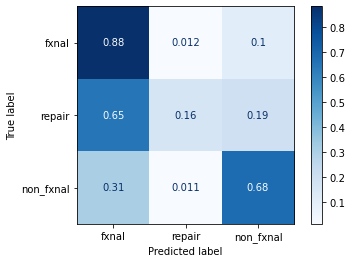

In [52]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> Poor performance on the "repair" class
>
> Maybe use techniques for imbalanced data

#### 4.1.2. KNNImputer (Same Performance as SimpleImputer)

In [53]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

knn_imputer = KNNImputer(n_neighbors=15)

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe2 = Pipeline([("ohe", mct), ("impu", knn_imputer), ("sc", ss), ("clf", logreg)])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train).round(3), pipe2.score(X_test, y_test).round(3)

(0.756, 0.753)

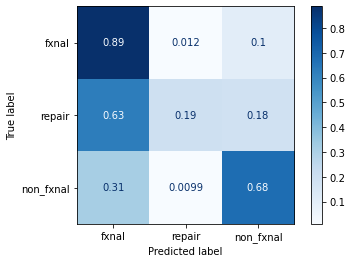

In [54]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

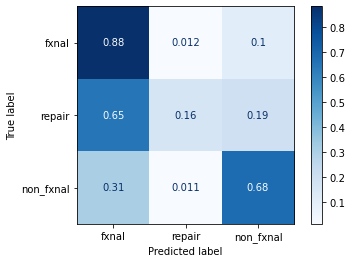

In [55]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

#### 4.1.3. Include 9 Numeric Features (No Difference)

In [56]:
num_feats = list(X.select_dtypes(include = "number").drop(columns = ["id"]).columns)
#list of numeric features

In [57]:
X_num_cat = X[num_feats + cat_feats]

In [58]:
X_num_cat.shape

(59400, 22)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

In [60]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe3 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train).round(3), pipe3.score(X_test, y_test).round(3)

(0.756, 0.753)

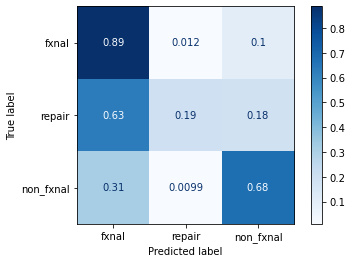

In [61]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

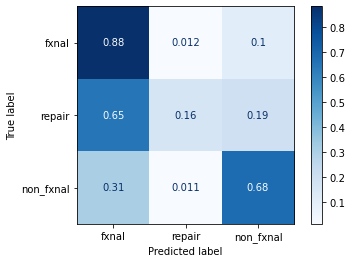

In [62]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> The 9 numeric features are not useful for prediction

In [65]:
X["lga"].str.lower().str.contains("zanzibar").sum()

0

In [66]:
X["ward"].str.lower().str.contains("zanzibar").sum()

0

In [67]:
X["region"].str.lower().str.contains("zanzibar").sum()

0

In [68]:
X["basin"].str.lower().str.contains("zanzibar").sum()

0

In [69]:
X["subvillage"].str.lower().str.contains("zanzibar").sum()

10

In [70]:
zanzibar = X["subvillage"].str.lower().str.contains("zanzibar")

In [77]:
X[zanzibar == True]["subvillage"]

7440     Zanzibar
7708     Zanzibar
19990    Zanzibar
22194    Zanzibar
30146    Zanzibar
51853    Zanzibar
54487    Zanzibar
55307    Zanzibar
55392    Zanzibar
56526    Zanzibar
Name: subvillage, dtype: object